# Background removal (for source detection)


The first step in detecting sources is to remove any background from the image. There are a number of ways to do this, ranging from subtracting a single value (typically the median or mean) from every pixel to more sophisticated methods either fit a slowly-varying shape to the background or that smooth the input image in some way.

There is probably not a single "best" way to do this; what matters is whether you are able to detect the sources you need to detect in the images you have.

Note that the way you do background removal for source detection does *not* need to be the same way you do it for photometry. It is perfectly fine to use the same method for both, of course, but it is not required.

## "Simple" approach: median or other scalar estimator of background 

The simplest way to estimate the background is with a single number, perhaps the mean or median of the data. The problem with that approach is that the distribution of pixel value in an astronomical image is not symmetric. Most of the pixels have values near zero while a small number have significantly higher values.

The [photutils] documentation on [scalar background and noise estimation](https://photutils.readthedocs.io/en/stable/background.html#scalar-background-and-noise-estimation) walk through this step-by-step, demonstrating the result you get with a variety of background estimators.

The upshot is that the best estimate of the background is obtained by first masking the sources in the image and then sigma clipping the unmasked parts of the data. The mean and median of the unmasked parts of the image give almost exactly the same value, and standard deviation recovered from the  data matches that of the input.

### Pixel distribution in simulated image

We begin by constructing a histogram of pixel values in a sample image. The code below illustrates a few useful things from astropy and photutils:

+ photutils comes with useful simulated images.
+ astropy comes with a histogram function that will automatically bin the data in a way that brings out features in your data that uniform-width bins might miss.
+ astropy has several stretches and normalizations to bring out features in astronomical images.


#### Simulated image: 100 Gaussian sources

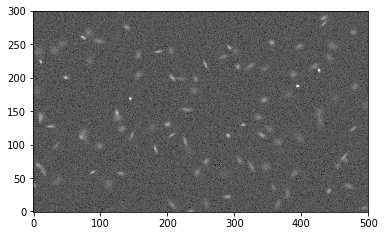

In [40]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from photutils.datasets import make_100gaussians_image
from photutils import make_source_mask, Background2D, MeanBackground, MADStdBackgroundRMS

from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import hist
from astropy.stats import sigma_clipped_stats, SigmaClip


data = make_100gaussians_image()

norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data, norm=norm, origin='lower', cmap='Greys_r')


#### Distribution of pixels

There are a couple of things to note about this distrubtion. 

The bulk of the pixel values are noise. The function `make_100gaussians_image` adds a background with a Gaussian distribution centered at 5 with a standard deviation of 2. The long tail at higher pixel values are from the sources in the image.

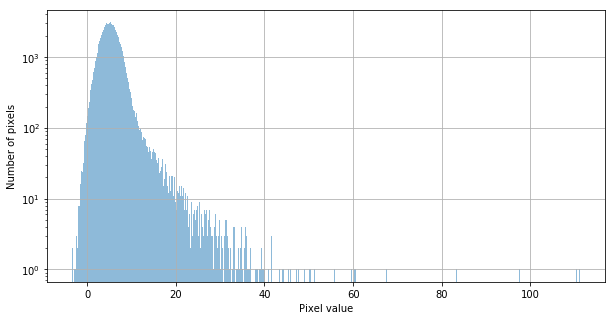

In [13]:
plt.figure(figsize=(10, 5))

# IMPORTANT NOTE: flattening the data to one dimension vastly reduces the 
# time it takes to histogram the data. 

h, bins, patches = hist(data.flatten(), bins='freedman', log=True,
                        alpha=0.5, label='Pixel values')
plt.xlabel('Pixel value')
plt.ylabel('Number of pixels')
# The semi-colon supresses a display of the grid object representation
plt.grid();

#### Estimating the background value

The plot below shows the result of several ways of estimating the background from the data. 

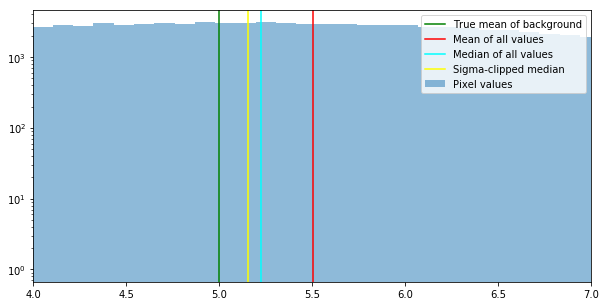

In [30]:
plt.figure(figsize=(10, 5))
hist(data.flatten(), bins='freedman', log=True,
                        alpha=0.5, label='Pixel values')
plt.xlim(4, 7)

true_mean = 5
avg_all_pixels = data.mean()
median_all_pixels = np.median(data)
plt.axvline(true_mean, label='True mean of background', color='green')
plt.axvline(avg_all_pixels, label='Mean of all values', color='red')
plt.axvline(median_all_pixels, label='Median of all values', color='cyan')

# Try sigma clipping
clipped_mean, clipped_med, clipped_std  = sigma_clipped_stats(data, sigma=3)

# Add line to chart
plt.axvline(clipped_med, label='Sigma-clipped median', color='yellow')
plt.legend();

None of the estimates above do a particularly good job of estimating the true background level. They also do not do a great job of estimating the error or noise in that background; the input value was 2, but the value produced by sigma clipping is larger:

In [23]:
std

2.094275212132969

### Best approach for single value

The best approach to deriving a single value to use for background is to first mask the sources; photutils provides a convenience function for that. Once that mask is applied, the true mean and noise level are recovered with reasonable accuracy.

5.001013475475569 5.000584905604376 1.970887100626572


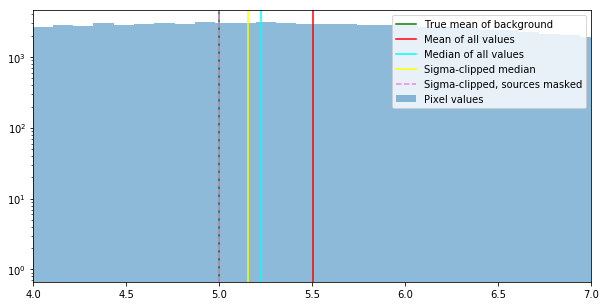

In [33]:
source_mask = make_source_mask(data, snr=2, npixels=5)
mask_clip_mean, mask_clip_med, mask_clip_std  = sigma_clipped_stats(data, sigma=3, mask=source_mask)

plt.figure(figsize=(10, 5))
hist(data.flatten(), bins='freedman', log=True,
                        alpha=0.5, label='Pixel values')
plt.xlim(4, 7)

plt.axvline(true_mean, label='True mean of background', color='green')
plt.axvline(avg_all_pixels, label='Mean of all values', color='red')
plt.axvline(median_all_pixels, label='Median of all values', color='cyan')
plt.axvline(clipped_med, label='Sigma-clipped median', color='yellow')
plt.axvline(mask_clip_med, label='Sigma-clipped, sources masked', 
            color='violet', linestyle='dashed')
plt.legend();

## Two dimensional background 

If the background is not uniform (as happens, for example, on a night with moonlight) then using a single value to represent that background will not be effective. Instead, one constructs a background array; it is constructed by breaking the image into pieces, calcuating a scalar background estimate as above, and building those back into a two-dimensional image. 

To do this with photutils requires making a few choices:

+ *What should the mesh size be?* This is the size, in pixels, of the chunks into which the image will be split for generating the background. It should be larger than the sources in the image, but small enough to represent variation in background across the image.
+ *How should the background in each mesh cell be calculated?* The full suite of options is listed in the [photutils documentation for 2D backgrounds](https://photutils.readthedocs.io/en/stable/background.html#d-background-and-noise-estimation). The example below uses the mean because the sources will be masked as in the scalar case. Other options include the median and `SExtractorBackground` for using the background method used by SExtractor.
+ *Do you want to also estimate the noise in the background, i.e. the RMS of the background?* Again, several options are available.
+ *How do you want the background image interpolated when it is scaled back up to the size of the input image?* By default spline interpolation is used, but it can be changed.


### Add some background to the input image

As with the rest of the examples in this notebook, we closely follow the example from the photutils documentation.

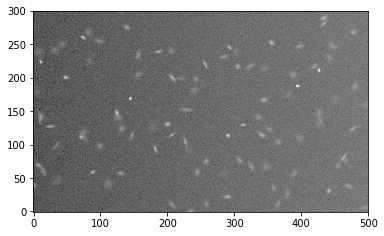

In [45]:
ny, nx = data.shape
y, x = np.mgrid[:ny, :nx]

gradient = x / 50.
gradient_median = np.median(gradient)
data2 = data + gradient
plt.imshow(data2, norm=norm, origin='lower', cmap='Greys_r')   

### Choose your options

For most of the choices in the list above, one creates an instance of the *class* corresponing to the choice.

In [85]:
# Choose sigma clip parameters

# Parameters below match those used in sigma_clipped_stats above. The 
# default in photutils is sigma=3, iters=10; this default is used unless
# you override it as shown below.
sigma_clip = SigmaClip(sigma=3., iters=5)

# Choose your background calculation method
bg_estimator = MeanBackground()

# Choose your mesh size...ideally, an integer number of these fits across
# the image. Here we use a size such that 10 meshes fit across the image
# in each directory.
mesh_size = (ny // 10, nx // 10)

# Choose an estimator for the noise in the background (i.e. RMS). The 
# default is to use standard deviation using StdBackgroundRMS. This
# example uses the median absolute deviation for the purposes of 
# illustration.
bg_rms_estimator = MADStdBackgroundRMS()

# We could, in principle, specify an interpolator for going from the small
# mesh to the full size image. By not specifying that we get the default,
# which is a spline interpolation; photutils calls this BgZoom

# Finally, construct the background. Each of the choices above are fed into 
# the initialization of the background object. 
bgd = Background2D(data2, mesh_size, 
                   sigma_clip=sigma_clip,
                   bkg_estimator=bg_estimator,
                   bkgrms_estimator=bg_rms_estimator,
                  )


## Display the background 

Though this is not required, we may as well check to see whether the inferred background matches the gradient in the x-direction that we added to the image.

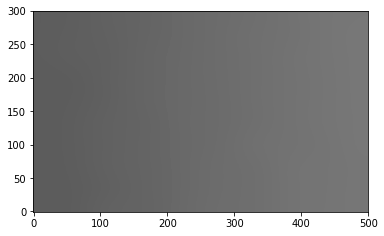

In [97]:
plt.imshow(bgd.background, norm=norm, origin='lower', cmap='Greys_r')

### Check: compare background-subtracted data to expected values

If the background has been properly substracted, then the median of the subtracted image should be zero (if we mask out the sources) and the rms should be around 2, the value that was used to generate the Gaussian noise in `make_100gaussians_image`.

In [101]:
back_sub_data = data2 - bgd.background

sub_mean, sub_med, sub_std  = sigma_clipped_stats(back_sub_data, 
                                                  sigma=3)

print(sub_mean, sub_med, sub_std)

0.025264474935314037 -0.01872212789955663 2.1259375730818832
